We use Kruksall-Wallis instead of ANOVA (non-parametric). We measure effect size with epsilon squared forumal

Script to produce these results is in ABM_experiment/Benchmark_HPC.py

In [46]:
import os
import pickle
import pandas as pd
import numpy as np
import scipy as sp


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import matplotlib as mpl

os.chdir('/Users/natachachenevoy/Documents/GitHub/ABM-Detroit-Police-Dispatch/ABM_experiments/')
print(os.getcwd())

# For example
with open('First results - increasing order/results_benchmark_scenario2.pkl','rb') as f:
    df = pickle.load(f)
df

/Users/natachachenevoy/Documents/GitHub/ABM-Detroit-Police-Dispatch/ABM_experiments


,num_agents,configuration,avg_response_time,percent_failed,deterrence
0,10,T,5.608696,3.571429,730
1,10,R,13.400000,9.523810,757
2,20,T,10.634921,5.952381,1763
3,20,R,10.106061,8.333333,1691
4,30,T,7.600000,7.142857,2422
...,...,...,...,...,...
1195,40,R,4.686567,0.000000,3340
1196,50,T,6.076923,5.970149,4523
1197,50,R,10.153846,10.447761,3986
1198,60,T,3.313433,0.000000,5269


In [47]:
# CHANEG HERE
alpha = 0.01

In [48]:
def plotBoxplots(configuration, ax, scenario, metric, title, ylabel, xlabel, ylim) :
    with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
        df = pickle.load(f)
        
    sns.boxplot(x="num_agents", y=metric, data=df[df['configuration'] == configuration], ax = ax)

    ax.set_xticklabels(ax.get_xticklabels(),rotation=0,  fontsize=15)

    ax.set_xlabel(xlabel, fontsize = 15)
    
    ax.set_ylabel(ylabel, fontsize = 15)
    
    ax.set_ylim(bottom=ylim[0], top=ylim[1])

    ax.tick_params(axis='y', labelsize=15)
    
    ax.set_title(title, fontsize = 16, )



In [49]:
def plotLinePlot(ax, scenario, metric, title, ylabel, xlabel, legend_title, legend_labels, legend_loc, ylim = None) :
 
    with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
        df = pickle.load(f)
   
    sns.lineplot(x="num_agents", y=metric, hue = 'configuration', data=df, marker='o', ax = ax)

    # Ticks
    #ax.set_xticklabels(ax.get_xticklabels(),rotation=0,  fontsize=15)

    ax.set_xlabel(xlabel, fontsize = 16)
    
    ax.set_ylabel(ylabel, fontsize = 16)
    
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    
    if ylim :
        ax.set_ylim(bottom=ylim[0], top=ylim[1])

    
    ax.set_title(title, fontsize = 16, )
    
    ax.legend(title=legend_title, loc=legend_loc, labels=legend_labels, fontsize = 16)
    
    
    leg = ax.get_legend()
    leg.set_title(legend_title)
    leg.get_title().set_fontsize('16')
    #leg.set_bbox_to_anchor((1.2,0))
    leg.get_texts()[0].set_fontsize('16')

    # position the legend box 
    #leg.set_bbox_to_anchor((1.45,0.15))

In [50]:
def plotConfigurationFacets(scenario, metric, title, ylabel) :
    with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
        df = pickle.load(f)
        df.rename(columns={"num_agents": "Number of agents"}, inplace=True)


    g = sns.catplot(
        data=df, x='configuration', y=metric,
        col='Number of agents', kind='box', col_wrap=3,
    )

    g.tight_layout(h_pad=5)

    g.set_axis_labels("Configuration", ylabel, fontsize = 15)
    g.set_xticklabels(["Targeted", "Random"], fontsize = 15)
    g.set_titles(title, size = 15)

    

I'm not aware of any package or library that can calculate epsilon square immediately, but the formula is not that complicated:

\begin{equation*}
\epsilon_{KW}^2 = H\times\frac{n+1}{n^2-1}
\end{equation*}

The $H$ is the test-value of the Kruskal-Wallis Test itself, and $n$ the sample size. 

In a separate documentation an explanation can be found on how to obtain the H-value, so see for more details the Kruskal-Wallis H test documentation. Here is quickly the code from that document:

In [51]:
def getPValueAndEffectSize(metric, num) :
    with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
        df = pickle.load(f)
        
    df_subset = df[df['num_agents']==num]
    H, pvalue = sp.stats.kruskal(*[group[metric].values for name, group in df_subset.groupby(["configuration"])])
    if pvalue < alpha :
        pvalue= "<0.01"
    else :
        pvalue = pvalue.round(2)
    
    qual = getEffectSize(H, df_subset)
    
    return [pvalue, qual]

In [52]:
def getEffectSize(H, df) :
    n = df.shape[0]
    
    esq = H * (n + 1)/(n**2 - 1)
    print('esq', esq)
    if esq < .01:
        qual = 'Negligible'
    elif esq < .04:
        qual = 'Weak'
    elif esq < .16:
        qual = 'Moderate'
    elif esq < .36:
        qual = 'Relatively strong'
    elif esq < .64:
        qual = 'Strong'
    else:
        qual = 'Very strong'

    #print('Effect size', esq, qual)
    return qual

## All results (raw)

In [53]:
scenario = 1
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)
    
res1 = df[['num_agents', 'configuration', 'avg_response_time']].groupby(by=['num_agents', 'configuration']).agg(['mean', 'std'])
#res1.reset_index(inplace=True)

res2 = df[['num_agents', 'configuration', 'percent_failed']].groupby(by=['num_agents', 'configuration']).agg(['mean', 'std'])
#res1.reset_index(inplace=True)

res3 = df[['num_agents', 'configuration', 'deterrence']].groupby(by=['num_agents', 'configuration']).agg(['mean', 'std'])
#res1.reset_index(inplace=True)

   
result = res1.merge(res2, left_index=True, right_index=True)
result = result.merge(res3, left_index=True, right_index=True)

result.rename(columns={"num_agents": "Number of agents", 'configuration': 'Configuration', 'avg_response_time': 'Average response time (mins)', 'percent_failed': 'Ratio failed responses (%)', 'deterrence': 'Total deterrence score'}, inplace=True)
result.round(1) 

Average response time (mins)       \
                                                 mean  std   
num_agents configuration                                     
10         R                                     14.2  8.2   
           T                                     16.2  9.5   
20         R                                     10.7  6.9   
           T                                      5.2  2.0   
30         R                                      7.6  5.1   
           T                                      6.7  2.8   
40         R                                      5.5  3.1   
           T                                      5.6  2.3   
50         R                                      4.3  1.1   
           T                                      4.3  1.4   
60         R                                      3.9  1.1   
           T                                      3.7  0.9   

                         Ratio failed responses (%)       \
                                               mean  std   
num_agents configuration                                   
10         R                                    8.0  6.0   
           T                                   10.1  6.4   
20         R                                    7.1  6.3   
           T                                    1.4  2.7   
30         R                                    4.4  4.9   
           T                                    3.6  3.6   
40         R                                    1.9  3.1   
           T                                    2.7  3.3   
50         R                                    0.6  1.7   
           T                                    1.1  2.4   
60         R                                    0.6  1.9   
           T                                    0.5  1.7   

                         Total deterrence score         
                                           mean    std  
num_agents configuration                                
10         R                              402.8   62.3  
           T                              390.5   46.0  
20         R                              837.2   83.4  
           T                              832.7   63.9  
30         R                             1263.9  110.3  
           T                             1334.6   79.0  
40         R                             1696.9  109.4  
           T                             1763.8   98.8  
50         R                             2129.9  131.0  
           T                             2239.7   95.3  
60         R                             2576.1  141.0  
           T                             2712.3  116.4

In [ ]:
# concat both scenario, group by num agent

avg_response_time            avg_time_patrolling              \
scenario                   1          2                   1           2   
num_agents                                                                
10                 15.164724  25.172830          328.003500  239.807000   
20                  7.923131  16.248387          358.213500  287.720250   
30                  7.111660  11.494603          368.400000  318.059833   
40                  5.587483   7.948692          381.972125  342.128875   
50                  4.281782   5.502396          389.004300  357.724900   
60                  3.840328   4.683704          395.070917  367.100083   

           deterrence           percent_failed             
scenario            1         2              1          2  
num_agents                                                 
10            396.670   721.985       9.074699  14.980062  
20            834.940  1573.245       4.245064  12.480599  
30           1299.240  2448.215       3.995872   9.437518  
40           1730.345  3348.760       2.305453   5.137570  
50           2184.805  4203.925       0.840678   2.733582  
60           2644.215  5044.380       0.522820   1.683838

In [129]:
with open('results_benchmark_scenario1.pkl'.format(scenario),'rb') as f:
    df1 = pickle.load(f)
    df1['scenario']= 1
with open('results_benchmark_scenario2.pkl'.format(scenario),'rb') as f:
    df2 = pickle.load(f)
    df2['scenario']= 2
df = pd.concat([df1,df2])
df.reset_index(inplace=True)
df

,index,num_agents,configuration,avg_response_time,percent_failed,deterrence,avg_time_patrolling,scenario
0,0,10,T,9.520000,5.714286,412,334.600000,1
1,1,10,R,5.619048,0.000000,427,326.000000,1
2,2,20,T,4.038462,0.000000,768,373.600000,1
3,3,20,R,5.320000,2.857143,867,377.800000,1
4,4,30,T,4.257143,0.000000,1296,376.566667,1
...,...,...,...,...,...,...,...,...
2395,1195,40,R,6.439394,2.985075,3140,366.950000,2
2396,1196,50,T,6.076923,5.970149,4468,378.720000,2
2397,1197,50,R,4.970149,4.477612,4301,376.420000,2
2398,1198,60,T,3.313433,0.000000,5269,385.516667,2


In [138]:
df2 = df[['index','avg_response_time', 'scenario', 'percent_failed', 'deterrence']].pivot_table(index='index', columns=['scenario'])

df2['configuration'] = df['configuration']
df2['num_agents'] = df['num_agents'].copy()
df2
res1 = df2.groupby(by=['num_agents', 'configuration']).agg(['mean', 'std'])

res1[['avg_response_time', 'percent_failed', 'deterrence']].round(2)

avg_response_time                     percent_failed  \
                                         1            2                     1   
                                      mean   std   mean    std           mean   
num_agents configuration                                                        
10         R                         14.17  8.19  31.47  16.11           8.02   
           T                         16.16  9.51  18.88  10.86          10.13   
20         R                         10.67  6.90  19.15  11.50           7.09   
           T                          5.18  1.95  13.35   6.83           1.40   
30         R                          7.56  5.06  11.86   6.36           4.43   
           T                          6.67  2.78  11.13   5.60           3.56   
40         R                          5.54  3.11   8.58   5.41           1.93   
           T                          5.64  2.28   7.31   3.49           2.68   
50         R                          4.26  1.14   5.74   3.01           0.55   
           T                          4.30  1.44   5.27   2.18           1.13   
60         R                          3.94  1.13   4.54   2.14           0.58   
           T                          3.74  0.88   4.82   1.99           0.46   

                                            deterrence                   \
                                    2                1                2   
                           std   mean   std       mean     std     mean   
num_agents configuration                                                  
10         R              6.04  17.33  7.68     402.82   62.27   725.23   
           T              6.41  12.63  6.49     390.52   46.04   718.74   
20         R              6.30  15.38  7.70     837.19   83.37  1554.12   
           T              2.66   9.58  5.24     832.69   63.92  1592.37   
30         R              4.94  10.28  6.09    1263.93  110.25  2425.48   
           T              3.61   8.59  4.50    1334.55   79.02  2470.95   
40         R              3.08   5.68  5.03    1696.92  109.44  3316.87   
           T              3.34   4.60  3.56    1763.77   98.81  3380.65   
50         R              1.66   2.98  3.53    2129.93  131.04  4178.57   
           T              2.40   2.49  2.75    2239.68   95.26  4229.28   
60         R              1.94   1.32  2.88    2576.11  140.99  5024.84   
           T              1.74   2.04  2.13    2712.32  116.45  5063.92   

                                  
                                  
                             std  
num_agents configuration          
10         R              130.68  
           T              134.32  
20         R              190.69  
           T              190.64  
30         R              231.81  
           T              218.43  
40         R              217.91  
           T              222.29  
50         R              262.27  
           T              214.95  
60         R              309.68  
           T              247.88

In [ ]:
scenario = 1
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)
    
res1 = df[['num_agents', 'configuration', 'avg_response_time']].groupby(by=['num_agents', 'configuration']).agg(['mean', 'std'])
#res1.reset_index(inplace=True)

res2 = df[['num_agents', 'configuration', 'percent_failed']].groupby(by=['num_agents', 'configuration']).agg(['mean', 'std'])
#res1.reset_index(inplace=True)

res3 = df[['num_agents', 'configuration', 'deterrence']].groupby(by=['num_agents', 'configuration']).agg(['mean', 'std'])
#res1.reset_index(inplace=True)

   
result = res1.merge(res2, left_index=True, right_index=True)
result = result.merge(res3, left_index=True, right_index=True)

result.rename(columns={"num_agents": "Number of agents", 'configuration': 'Configuration', 'avg_response_time': 'Average response time (mins)', 'percent_failed': 'Ratio failed responses (%)', 'deterrence': 'Total deterrence score'}, inplace=True)
result.round(1) 

In [54]:
scenario = 2
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)
    
res1 = df[['num_agents', 'configuration', 'avg_response_time']].groupby(by=['num_agents', 'configuration']).agg(['mean', 'std'])
#res1.reset_index(inplace=True)

res2 = df[['num_agents', 'configuration', 'percent_failed']].groupby(by=['num_agents', 'configuration']).agg(['mean', 'std'])
#res1.reset_index(inplace=True)

res3 = df[['num_agents', 'configuration', 'deterrence']].groupby(by=['num_agents', 'configuration']).agg(['mean', 'std'])
#res1.reset_index(inplace=True)

   
result = res1.merge(res2, left_index=True, right_index=True)
result = result.merge(res3, left_index=True, right_index=True)

result.rename(columns={"num_agents": "Number of agents", 'configuration': 'Configuration', 'avg_response_time': 'Average response time (mins)', 'percent_failed': 'Ratio failed responses (%)', 'deterrence': 'Total deterrence score'}, inplace=True)
result.round(1) 

Average response time (mins)        \
                                                 mean   std   
num_agents configuration                                      
10         R                                     31.5  16.1   
           T                                     18.9  10.9   
20         R                                     19.1  11.5   
           T                                     13.4   6.8   
30         R                                     11.9   6.4   
           T                                     11.1   5.6   
40         R                                      8.6   5.4   
           T                                      7.3   3.5   
50         R                                      5.7   3.0   
           T                                      5.3   2.2   
60         R                                      4.5   2.1   
           T                                      4.8   2.0   

                         Ratio failed responses (%)       \
                                               mean  std   
num_agents configuration                                   
10         R                                   17.3  7.7   
           T                                   12.6  6.5   
20         R                                   15.4  7.7   
           T                                    9.6  5.2   
30         R                                   10.3  6.1   
           T                                    8.6  4.5   
40         R                                    5.7  5.0   
           T                                    4.6  3.6   
50         R                                    3.0  3.5   
           T                                    2.5  2.7   
60         R                                    1.3  2.9   
           T                                    2.0  2.1   

                         Total deterrence score         
                                           mean    std  
num_agents configuration                                
10         R                              725.2  130.7  
           T                              718.7  134.3  
20         R                             1554.1  190.7  
           T                             1592.4  190.6  
30         R                             2425.5  231.8  
           T                             2471.0  218.4  
40         R                             3316.9  217.9  
           T                             3380.6  222.3  
50         R                             4178.6  262.3  
           T                             4229.3  215.0  
60         R                             5024.8  309.7  
           T                             5063.9  247.9

## Response time

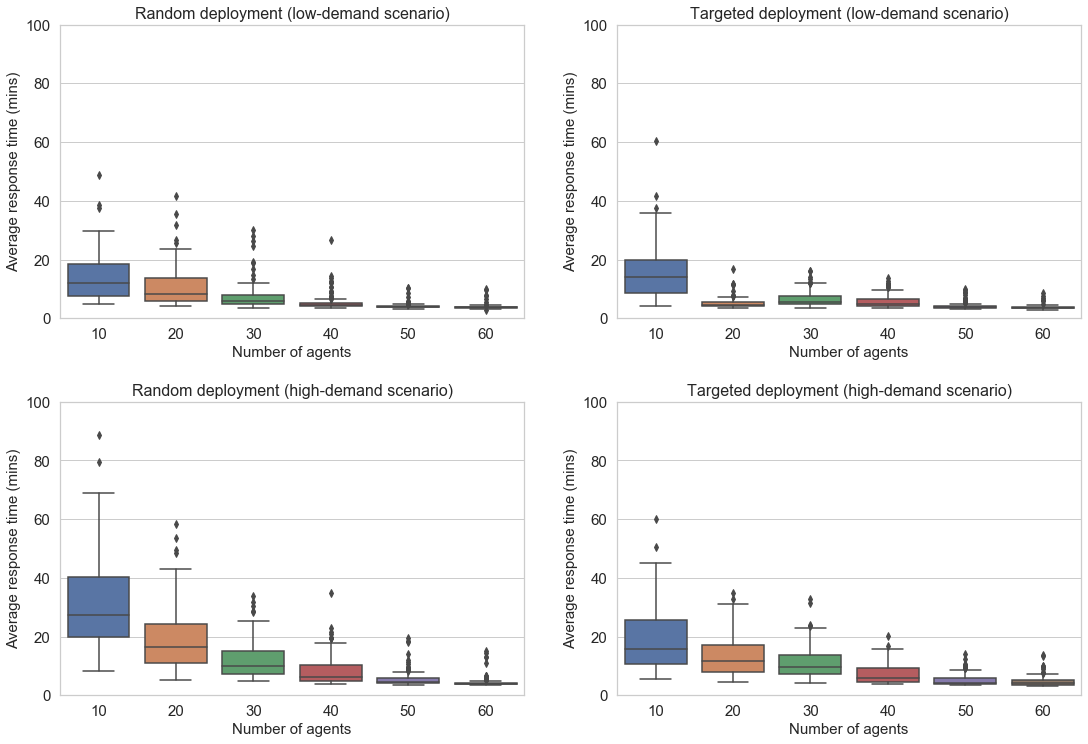

In [55]:
f, axes = plt.subplots(2, 2, figsize=(15, 10))
f.tight_layout(h_pad=5, w_pad=5)

# Scenario 1
plotBoxplots('R', axes[0][0],  scenario = 1, metric = 'avg_response_time', 
             title = 'Random deployment (low-demand scenario)', 
             ylabel= 'Average response time (mins)', 
             xlabel='Number of agents',
             ylim = [0,100]
            )
plotBoxplots('T', axes[0][1],  scenario = 1, metric= 'avg_response_time', 
             title = 'Targeted deployment (low-demand scenario)', 
             ylabel= 'Average response time (mins)', 
             xlabel='Number of agents',
             ylim = [0,100]
            )

# Scenario 2
plotBoxplots('R', axes[1][0],  scenario = 2, metric = 'avg_response_time', 
             title = 'Random deployment (high-demand scenario)', 
             ylabel= 'Average response time (mins)', 
             xlabel='Number of agents',
             ylim = [0,100]
            )
plotBoxplots('T', axes[1][1],  scenario = 2, metric = 'avg_response_time', 
             title = 'Targeted deployment (high-demand scenario)', 
             ylabel= 'Average response time (mins)', 
             xlabel='Number of agents',
             ylim = [0,100]
            )


plt.savefig('../Images/ABM_experiments_AvgResponseTime.png', bbox_inches = 'tight')

plt.show()

Note: In high demand scenario, the targeted configuration is the most relevant. A small improvement on the random one in low demand but mainly in high demand is most useful!

### Difference between number of agents

In [56]:
scenario = 1

print('Sceanrio:', scenario)
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)
        
H, p = sp.stats.kruskal(*[group["avg_response_time"].values for name, group in df.groupby('num_agents')])
print('H: {} - p-value: {}'.format(H, p))
if p > alpha:
    print('\nThe groups are NOT significantly different (fails to reject the null hypothesis)')
else:
    print('\nThe groups are significantly different (reject the null hypothesis)')

getEffectSize(H, df)

Sceanrio: 1
H: 710.6219507922768 - p-value: 2.4803496555859753e-151

The groups are significantly different (reject the null hypothesis)
esq 0.5926788580419323


'Strong'

In [57]:
scenario = 2

print('Sceanrio:', scenario)
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)
        
H, p = sp.stats.kruskal(*[group["avg_response_time"].values for name, group in df.groupby('num_agents')])
print('H: {} - p-value: {}'.format(H, p))
if p > alpha:
    print('\nThe groups are NOT significantly different (fails to reject the null hypothesis)')
else:
    print('\nThe groups are significantly different (reject the null hypothesis)')

getEffectSize(H, df)

Sceanrio: 2
H: 735.2614647380688 - p-value: 1.1648067008446141e-156

The groups are significantly different (reject the null hypothesis)
esq 0.6132289113745361


'Strong'

### Difference between random versus targeted configurations (for a given number of agents)

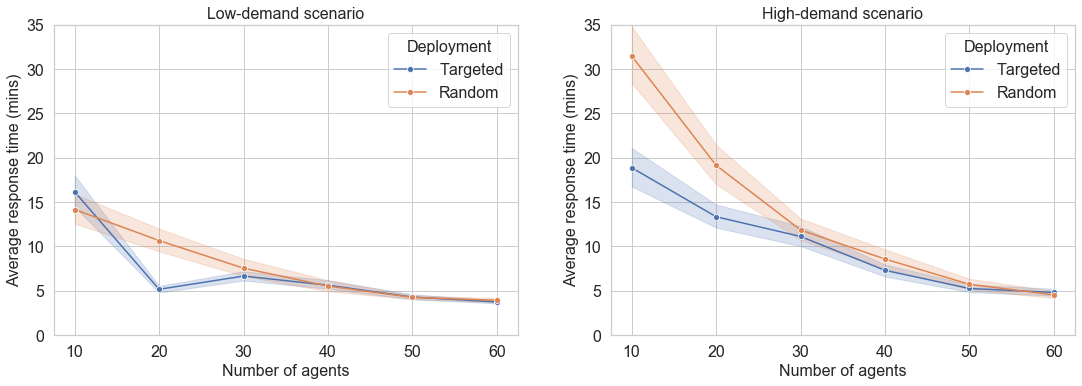

In [140]:
f, axes = plt.subplots(1, 2, figsize=(15, 5))
f.tight_layout(h_pad=5, w_pad=5)
sns.set_theme(style="whitegrid")
plotLinePlot(axes[0], scenario = 1, metric = 'avg_response_time', 
             title = 'Low-demand scenario', 
             ylabel= 'Average response time (mins)', 
             xlabel='Number of agents',
             ylim = [0,35],
             legend_title = 'Deployment',
             legend_labels = ['Targeted', 'Random'],
             legend_loc = 'upper right'
            )

plotLinePlot(axes[1], scenario = 2, metric = 'avg_response_time', 
             title = 'High-demand scenario', 
             ylabel= 'Average response time (mins)', 
             xlabel='Number of agents',
             ylim = [0,35],
             legend_title = 'Deployment',
             legend_labels = ['Targeted', 'Random'],
             legend_loc = 'upper right'
            )

plt.savefig('../Images/ABM_experiments_AvgResponseTime2.png', bbox_inches = 'tight')



In [59]:
scenario = 1
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)

### AVERAGE RESPONSE TIME
res1 = df[['num_agents', 'configuration', 'avg_response_time']].groupby(by=['num_agents', 'configuration']).mean()

res1.reset_index(inplace=True)

result = pd.pivot(res1, index='num_agents', columns='configuration', values='avg_response_time')
result['Mean difference (mins)'] = result['T'] - result['R'] 
result['Percentage change'] = result['Mean difference (mins)'] / result['R'] * 100

result.reset_index(inplace=True)

result['p-value'] = [getPValueAndEffectSize('avg_response_time', num)[0] for num in result['num_agents']]
result['Effect size'] = [getPValueAndEffectSize('avg_response_time', num)[1] for num in result['num_agents']]

result.round(2)

esq 0.012792647383097959
esq 0.43813306422277104
esq 0.0012120693922554942
esq 0.008927390944662057
esq 0.03817545207156374
esq 0.04417963230198292
esq 0.012792647383097959
esq 0.43813306422277104
esq 0.0012120693922554942
esq 0.008927390944662057
esq 0.03817545207156374
esq 0.04417963230198292


configuration,num_agents,R,T,Mean difference (mins),Percentage change,p-value,Effect size
0,10,14.17,16.16,1.99,14.07,0.11,Weak
1,20,10.67,5.18,-5.49,-51.47,<0.01,Strong
2,30,7.56,6.67,-0.89,-11.79,0.62,Negligible
3,40,5.54,5.64,0.10,1.83,0.18,Negligible
4,50,4.26,4.30,0.04,0.90,<0.01,Weak
5,60,3.94,3.74,-0.19,-4.93,<0.01,Moderate


In [60]:
scenario = 2
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)

### AVERAGE RESPONSE TIME
res1 = df[['num_agents', 'configuration', 'avg_response_time']].groupby(by=['num_agents', 'configuration']).mean()

res1.reset_index(inplace=True)

result = pd.pivot(res1, index='num_agents', columns='configuration', values='avg_response_time')
result['Mean difference (mins)'] = result['T'] - result['R'] 
result['Percentage change'] = result['Mean difference (mins)'] / result['R'] * 100


result.reset_index(inplace=True)

result['p-value'] = [getPValueAndEffectSize('avg_response_time', num)[0] for num in result['num_agents']]
result['Effect size'] = [getPValueAndEffectSize('avg_response_time', num)[1] for num in result['num_agents']]


result.round(2)

esq 0.19707414465922468
esq 0.07133481037247483
esq 0.0014785569639242974
esq 0.010764331401279458
esq 0.02614337990710202
esq 0.00871593287866737
esq 0.19707414465922468
esq 0.07133481037247483
esq 0.0014785569639242974
esq 0.010764331401279458
esq 0.02614337990710202
esq 0.00871593287866737


configuration,num_agents,R,T,Mean difference (mins),Percentage change,p-value,Effect size
0,10,31.47,18.88,-12.59,-40.01,<0.01,Relatively strong
1,20,19.15,13.35,-5.79,-30.27,<0.01,Moderate
2,30,11.86,11.13,-0.73,-6.16,0.59,Negligible
3,40,8.58,7.31,-1.27,-14.78,0.14,Weak
4,50,5.74,5.27,-0.47,-8.26,0.02,Weak
5,60,4.54,4.82,0.28,6.18,0.19,Negligible


In [61]:
"""scenario = 1
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)
    
res1 = df[['num_agents', 'configuration', 'avg_response_time']].groupby(by=['num_agents', 'configuration']).agg(['mean', 'std'])
#res1.reset_index(inplace=True)


scenario = 2
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)
    
res2 = df[['num_agents', 'configuration', 'avg_response_time']].groupby(by=['num_agents', 'configuration']).agg(['mean', 'std'])
#res2.reset_index(inplace=True)

result = res1.merge(res2, left_index=True, right_index=True)
result.rename(columns={"num_agents": "Number of agents", 'configuration': 'Configuration', 'avg_response_time_x': 'Low-demand', 'avg_response_time_y': 'High-demand'}, inplace=True)
result.round(1) """

'scenario = 1\nwith open(\'results_benchmark_scenario{}.pkl\'.format(scenario),\'rb\') as f:\n    df = pickle.load(f)\n    \nres1 = df[[\'num_agents\', \'configuration\', \'avg_response_time\']].groupby(by=[\'num_agents\', \'configuration\']).agg([\'mean\', \'std\'])\n#res1.reset_index(inplace=True)\n\n\nscenario = 2\nwith open(\'results_benchmark_scenario{}.pkl\'.format(scenario),\'rb\') as f:\n    df = pickle.load(f)\n    \nres2 = df[[\'num_agents\', \'configuration\', \'avg_response_time\']].groupby(by=[\'num_agents\', \'configuration\']).agg([\'mean\', \'std\'])\n#res2.reset_index(inplace=True)\n\nresult = res1.merge(res2, left_index=True, right_index=True)\nresult.rename(columns={"num_agents": "Number of agents", \'configuration\': \'Configuration\', \'avg_response_time_x\': \'Low-demand\', \'avg_response_time_y\': \'High-demand\'}, inplace=True)\nresult.round(1) '

In [62]:
"""plotConfigurationFacets(scenario=1, metric = 'avg_response_time', 
             title = '{col_name} agents', 
             ylabel="Average response time (mins)",)

plt.savefig('../Images/ABM_experiments_AvgResponseTime_Configurations_Scenario1.png', bbox_inches = 'tight')
"""


'plotConfigurationFacets(scenario=1, metric = \'avg_response_time\', \n             title = \'{col_name} agents\', \n             ylabel="Average response time (mins)",)\n\nplt.savefig(\'../Images/ABM_experiments_AvgResponseTime_Configurations_Scenario1.png\', bbox_inches = \'tight\')\n'

In [63]:
"""scenario = 1

print('Scenario:', scenario)
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)

for num in df['num_agents'].unique() :
    print('\n',num, 'agents')
    df_subset = df[df['num_agents']==num]
    H, p = sp.stats.kruskal(*[group["avg_response_time"].values for name, group in df_subset.groupby(["configuration"])])
    print('H: {} - p-value: {}'.format(H, p))
    if p > alpha:
        print('The groups are NOT significantly different (fails to reject the null hypothesis)')
    else:
        print('*** The groups are significantly different (reject the null hypothesis)')
    getEffectSize(H, df_subset)


"""

'scenario = 1\n\nprint(\'Scenario:\', scenario)\nwith open(\'results_benchmark_scenario{}.pkl\'.format(scenario),\'rb\') as f:\n    df = pickle.load(f)\n\nfor num in df[\'num_agents\'].unique() :\n    print(\'\n\',num, \'agents\')\n    df_subset = df[df[\'num_agents\']==num]\n    H, p = sp.stats.kruskal(*[group["avg_response_time"].values for name, group in df_subset.groupby(["configuration"])])\n    print(\'H: {} - p-value: {}\'.format(H, p))\n    if p > alpha:\n        print(\'The groups are NOT significantly different (fails to reject the null hypothesis)\')\n    else:\n        print(\'*** The groups are significantly different (reject the null hypothesis)\')\n    getEffectSize(H, df_subset)\n\n\n'

In [64]:
"""plotConfigurationFacets(scenario=2, metric = 'avg_response_time', 
             title = '{col_name} agents', 
             ylabel="Average response time (mins)",)

plt.savefig('../Images/ABM_experiments_AvgResponseTime_Configurations_Scenario2.png', bbox_inches = 'tight')

"""

'plotConfigurationFacets(scenario=2, metric = \'avg_response_time\', \n             title = \'{col_name} agents\', \n             ylabel="Average response time (mins)",)\n\nplt.savefig(\'../Images/ABM_experiments_AvgResponseTime_Configurations_Scenario2.png\', bbox_inches = \'tight\')\n\n'

In [65]:
"""scenario = 2

print('Scenario:', scenario)
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)

for num in df['num_agents'].unique() :
    print('\n',num, 'agents')
    df_subset = df[df['num_agents']==num]
    H, p = sp.stats.kruskal(*[group["avg_response_time"].values for name, group in df_subset.groupby(["configuration"])])
    print('H: {} - p-value: {}'.format(H, p))
    if p > alpha:
        print('The groups are NOT significantly different (fails to reject the null hypothesis)')
    else:
        print('*** The groups are significantly different (reject the null hypothesis)')
    getEffectSize(H, df_subset)


"""

'scenario = 2\n\nprint(\'Scenario:\', scenario)\nwith open(\'results_benchmark_scenario{}.pkl\'.format(scenario),\'rb\') as f:\n    df = pickle.load(f)\n\nfor num in df[\'num_agents\'].unique() :\n    print(\'\n\',num, \'agents\')\n    df_subset = df[df[\'num_agents\']==num]\n    H, p = sp.stats.kruskal(*[group["avg_response_time"].values for name, group in df_subset.groupby(["configuration"])])\n    print(\'H: {} - p-value: {}\'.format(H, p))\n    if p > alpha:\n        print(\'The groups are NOT significantly different (fails to reject the null hypothesis)\')\n    else:\n        print(\'*** The groups are significantly different (reject the null hypothesis)\')\n    getEffectSize(H, df_subset)\n\n\n'

## Crime deterrence

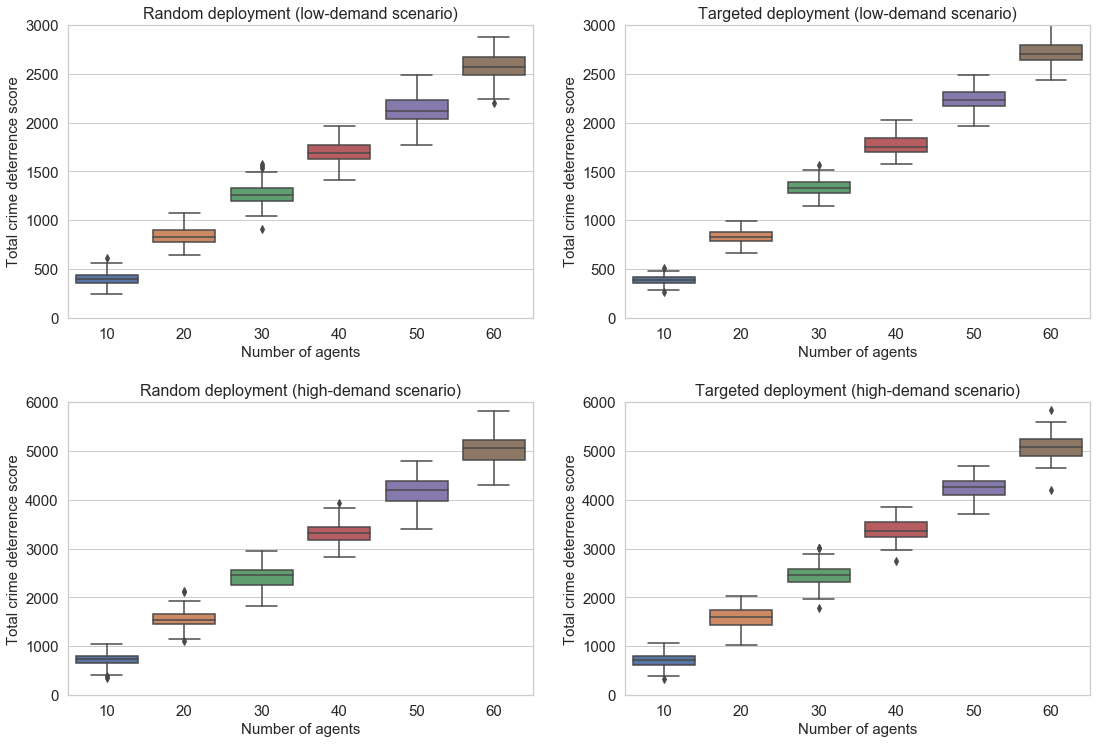

In [66]:
f, axes = plt.subplots(2, 2, figsize=(15, 10))
f.tight_layout(h_pad=5, w_pad=5)

# Scenario 1
plotBoxplots('R', axes[0][0], scenario = 1, metric = 'deterrence', 
             title = 'Random deployment (low-demand scenario)', 
             ylabel= 'Total crime deterrence score', 
             xlabel='Number of agents',
             ylim = [0,3000]
            )
plotBoxplots('T', axes[0][1], scenario = 1, metric ='deterrence', 
             title = 'Targeted deployment (low-demand scenario)', 
             ylabel= 'Total crime deterrence score', 
             xlabel='Number of agents',
             ylim = [0,3000]
            )


# Scenario 2
plotBoxplots('R', axes[1][0], scenario = 2, metric = 'deterrence', 
             title = 'Random deployment (high-demand scenario)', 
             ylabel= 'Total crime deterrence score', 
             xlabel='Number of agents',
             ylim = [0,6000]
            )
plotBoxplots('T', axes[1][1], scenario = 2, metric ='deterrence', 
             title = 'Targeted deployment (high-demand scenario)', 
             ylabel= 'Total crime deterrence score', 
             xlabel='Number of agents',
             ylim = [0,6000]
            )


plt.savefig('../Images/ABM_experiments_CrimeDeterrence.png', bbox_inches = 'tight')


plt.show()

Note: The edges of the graph for Scenario 2 also have a higher crime score so patrolling the, even for a little bit will yield a higher crime deterrence score than for scenario 1. With the targeted configuration, the agents are placed in patrol beats that have a high number of CFS (and presumably that corresponds to a high number of crimes too) thus when they patrol, they prevent more crimes.

In [67]:
def plotTimePatrolling() :
    with open('results_benchmark_scenario1.pkl'.format(scenario),'rb') as f:
        df1 = pickle.load(f)
        df1['scenario'] = np.repeat('Low-demand', len(df1))
    with open('results_benchmark_scenario2.pkl'.format(scenario),'rb') as f:
        df2 = pickle.load(f)
        df2['scenario'] = np.repeat('High-demand', len(df2))
    
    df = pd.concat([df1, df2])
    #df = df[df['configuration'] == 'T']
    ax = sns.lineplot(x="num_agents", y="avg_time_patrolling", hue = 'scenario', data=df, marker='o')

    # Ticks

    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

    ax.set_ylabel('Average patrolling time (mins)', fontsize = 16)  

    ax.set_xlabel("Number of agents", fontsize = 16)  
    
    leg = ax.get_legend()
    leg.set_title('Scenario')
    leg.get_title().set_fontsize('16')
    #leg.set_bbox_to_anchor((1.2,0))
    leg.get_texts()[0].set_fontsize('16')
        
    """# LEGEND
    if legend == False :
        ax.set_title('Scenario 2', fontsize = 20, ) # fontweight='bold'
        ax.get_legend().remove() # remove legend for second graph
    else :
        ax.set_title('Scenario 1', fontsize = 20)
        leg = ax.get_legend()
        leg.set_title('Number of agents per precinct')
        leg.get_title().set_fontsize('16')
        #leg.set_bbox_to_anchor((1.2,0))
        leg.get_texts()[0].set_fontsize('16')
        # position the legend box 
        leg.set_bbox_to_anchor((1.45,0.15))"""

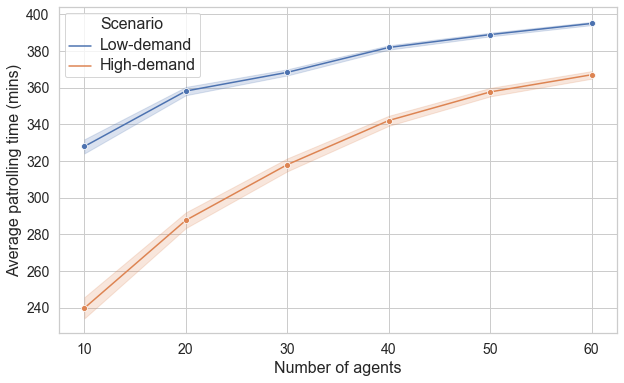

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# the content of labels of these yticks
sns.set_theme(style="whitegrid")
plotTimePatrolling()
plt.savefig('../Images/ABM_experiments_TimePatrolling.png', bbox_inches = 'tight')


### Difference between number of agents

In [69]:
scenario = 1

print('Sceanrio:', scenario)
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)
        
H, p = sp.stats.kruskal(*[group["deterrence"].values for name, group in df.groupby('num_agents')])
print('H: {} - p-value: {}'.format(H, p))
if p > alpha:
    print('\nThe groups are NOT significantly different (fails to reject the null hypothesis)')
else:
    print('\nThe groups are significantly different (reject the null hypothesis)')

getEffectSize(H, df)

Sceanrio: 1
H: 1163.2835689230596 - p-value: 2.634203268761453e-249

The groups are significantly different (reject the null hypothesis)
esq 0.9702114836722765


'Very strong'

In [70]:
scenario = 2

print('Sceanrio:', scenario)
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)
        
H, p = sp.stats.kruskal(*[group["deterrence"].values for name, group in df.groupby('num_agents')])
print('H: {} - p-value: {}'.format(H, p))
if p > alpha:
    print('\nThe groups are NOT significantly different (fails to reject the null hypothesis)')
else:
    print('\nThe groups are significantly different (reject the null hypothesis)')
    
getEffectSize(H, df)

Sceanrio: 2
H: 1162.8376335171783 - p-value: 3.2902855007683003e-249

The groups are significantly different (reject the null hypothesis)
esq 0.9698395608983973


'Very strong'

### Difference between random verus targeted configuration (for a given number of agents)

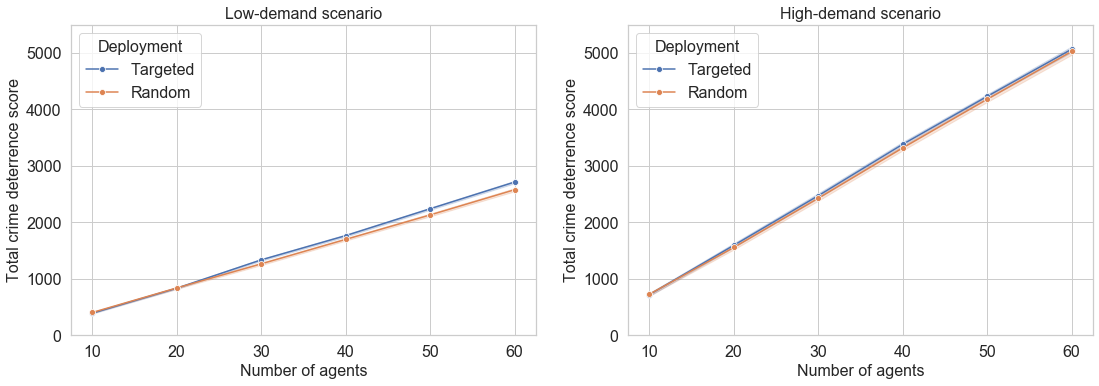

In [144]:
f, axes = plt.subplots(1, 2, figsize=(15, 5))
f.tight_layout(h_pad=5, w_pad=5)

plotLinePlot(axes[0], scenario = 1, metric = 'deterrence', 
             title = 'Low-demand scenario', 
             ylabel= 'Total crime deterrence score', 
             xlabel='Number of agents',
             ylim = [0,5500],
             legend_title = 'Deployment',
             legend_labels = ['Targeted', 'Random'],
             legend_loc = 'upper left'
            )

plotLinePlot(axes[1], scenario = 2, metric = 'deterrence', 
             title = 'High-demand scenario', 
             ylabel= 'Total crime deterrence score', 
             xlabel='Number of agents',
             ylim = [0,5500],
             legend_title = 'Deployment',
             legend_labels = ['Targeted', 'Random'],
             legend_loc = 'upper left'
            )

plt.savefig('../Images/ABM_experiments_CrimeDeterrence2.png', bbox_inches = 'tight')



In [87]:
scenario = 1
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)

### AVERAGE RESPONSE TIME
res1 = df[['num_agents', 'configuration', 'deterrence']].groupby(by=['num_agents', 'configuration']).mean()

res1.reset_index(inplace=True)

result = pd.pivot(res1, index='num_agents', columns='configuration', values='deterrence')
result['Mean difference'] = result['T'] - result['R'] 
result['Percentage change'] = result['Mean difference'] / result['R'] * 100


result.reset_index(inplace=True)

result['p-value'] = [getPValueAndEffectSize('deterrence', num)[0] for num in result['num_agents']]
result['Effect size'] = [getPValueAndEffectSize('deterrence', num)[1] for num in result['num_agents']]

result.round(2)

esq 0.006307695654391715
esq 0.00030605624432322764
esq 0.12930145831723855
esq 0.07868897474496296
esq 0.18266947436320566
esq 0.2114032103337914
esq 0.006307695654391715
esq 0.00030605624432322764
esq 0.12930145831723855
esq 0.07868897474496296
esq 0.18266947436320566
esq 0.2114032103337914


configuration,num_agents,R,T,Mean difference,Percentage change,p-value,Effect size
0,10,402.82,390.52,-12.30,-3.05,0.26,Negligible
1,20,837.19,832.69,-4.50,-0.54,0.81,Negligible
2,30,1263.93,1334.55,70.62,5.59,<0.01,Moderate
3,40,1696.92,1763.77,66.85,3.94,<0.01,Moderate
4,50,2129.93,2239.68,109.75,5.15,<0.01,Relatively strong
5,60,2576.11,2712.32,136.21,5.29,<0.01,Relatively strong


In [88]:
scenario = 2
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)

### AVERAGE RESPONSE TIME
res1 = df[['num_agents', 'configuration', 'deterrence']].groupby(by=['num_agents', 'configuration']).mean()

res1.reset_index(inplace=True)

result = pd.pivot(res1, index='num_agents', columns='configuration', values='deterrence')
result['Mean difference'] = result['T'] - result['R'] 
result['Percentage change'] = result['Mean difference'] / result['R'] * 100


result.reset_index(inplace=True)

result['p-value'] = [getPValueAndEffectSize('deterrence', num)[0] for num in result['num_agents']]
result['Effect size'] = [getPValueAndEffectSize('deterrence', num)[1] for num in result['num_agents']]

result.round(2)

esq 0.0011940937732750887
esq 0.014159848791683374
esq 0.009408432787908204
esq 0.019080965049326073
esq 0.010746618264185765
esq 0.003227656368481592
esq 0.0011940937732750887
esq 0.014159848791683374
esq 0.009408432787908204
esq 0.019080965049326073
esq 0.010746618264185765
esq 0.003227656368481592


configuration,num_agents,R,T,Mean difference,Percentage change,p-value,Effect size
0,10,725.23,718.74,-6.49,-0.89,0.63,Negligible
1,20,1554.12,1592.37,38.25,2.46,0.09,Weak
2,30,2425.48,2470.95,45.47,1.87,0.17,Negligible
3,40,3316.87,3380.65,63.78,1.92,0.05,Weak
4,50,4178.57,4229.28,50.71,1.21,0.14,Weak
5,60,5024.84,5063.92,39.08,0.78,0.42,Negligible


In [74]:
"""scenario = 1
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)
    
res1 = df[['num_agents', 'configuration', 'deterrence']].groupby(by=['num_agents', 'configuration']).agg(['mean', 'std'])
#res1.reset_index(inplace=True)


scenario = 2
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)
    
res2 = df[['num_agents', 'configuration', 'deterrence']].groupby(by=['num_agents', 'configuration']).agg(['mean', 'std'])
#res2.reset_index(inplace=True)

result = res1.merge(res2, left_index=True, right_index=True)
result.rename(columns={"num_agents": "Number of agents", 'configuration': 'Configuration', 'deterrence_x': 'Low-demand', 'deterrence_y': 'High-demand'}, inplace=True)
result.round(1) """

'scenario = 1\nwith open(\'results_benchmark_scenario{}.pkl\'.format(scenario),\'rb\') as f:\n    df = pickle.load(f)\n    \nres1 = df[[\'num_agents\', \'configuration\', \'deterrence\']].groupby(by=[\'num_agents\', \'configuration\']).agg([\'mean\', \'std\'])\n#res1.reset_index(inplace=True)\n\n\nscenario = 2\nwith open(\'results_benchmark_scenario{}.pkl\'.format(scenario),\'rb\') as f:\n    df = pickle.load(f)\n    \nres2 = df[[\'num_agents\', \'configuration\', \'deterrence\']].groupby(by=[\'num_agents\', \'configuration\']).agg([\'mean\', \'std\'])\n#res2.reset_index(inplace=True)\n\nresult = res1.merge(res2, left_index=True, right_index=True)\nresult.rename(columns={"num_agents": "Number of agents", \'configuration\': \'Configuration\', \'deterrence_x\': \'Low-demand\', \'deterrence_y\': \'High-demand\'}, inplace=True)\nresult.round(1) '

In [75]:
"""plotConfigurationFacets(scenario=1, metric = 'deterrence', 
             title = '{col_name} agents', 
             ylabel="Total crime deterrence score",)

plt.savefig('../Images/ABM_experiments_CrimeDeterrence_Configurations_Scenario1.png', bbox_inches = 'tight')

"""

'plotConfigurationFacets(scenario=1, metric = \'deterrence\', \n             title = \'{col_name} agents\', \n             ylabel="Total crime deterrence score",)\n\nplt.savefig(\'../Images/ABM_experiments_CrimeDeterrence_Configurations_Scenario1.png\', bbox_inches = \'tight\')\n\n'

In [76]:
"""scenario = 1

print('Scenario:', scenario)
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)

for num in df['num_agents'].unique() :
    print('\n',num, 'agents')
    df_subset = df[df['num_agents']==num]
    H, p = sp.stats.kruskal(*[group["deterrence"].values for name, group in df_subset.groupby(["configuration"])])
    print('H: {} - p-value: {}'.format(H, p))
    if p > alpha:
        print('The groups are NOT significantly different (fails to reject the null hypothesis)')
    else:
        print('*** The groups are significantly different (reject the null hypothesis)')
    getEffectSize(H, df_subset)
"""


'scenario = 1\n\nprint(\'Scenario:\', scenario)\nwith open(\'results_benchmark_scenario{}.pkl\'.format(scenario),\'rb\') as f:\n    df = pickle.load(f)\n\nfor num in df[\'num_agents\'].unique() :\n    print(\'\n\',num, \'agents\')\n    df_subset = df[df[\'num_agents\']==num]\n    H, p = sp.stats.kruskal(*[group["deterrence"].values for name, group in df_subset.groupby(["configuration"])])\n    print(\'H: {} - p-value: {}\'.format(H, p))\n    if p > alpha:\n        print(\'The groups are NOT significantly different (fails to reject the null hypothesis)\')\n    else:\n        print(\'*** The groups are significantly different (reject the null hypothesis)\')\n    getEffectSize(H, df_subset)\n'

In [77]:
"""plotConfigurationFacets(scenario=2, metric = 'deterrence', 
             title = '{col_name} agents', 
             ylabel="Total crime deterrence score",)

plt.savefig('../Images/ABM_experiments_CrimeDeterrence_Configurations_Scenario2.png', bbox_inches = 'tight')
"""


'plotConfigurationFacets(scenario=2, metric = \'deterrence\', \n             title = \'{col_name} agents\', \n             ylabel="Total crime deterrence score",)\n\nplt.savefig(\'../Images/ABM_experiments_CrimeDeterrence_Configurations_Scenario2.png\', bbox_inches = \'tight\')\n'

In [78]:
"""scenario = 2

print('Scenario:', scenario)
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)

for num in df['num_agents'].unique() :
    print('\n',num, 'agents')
    df_subset = df[df['num_agents']==num]
    H, p = sp.stats.kruskal(*[group["deterrence"].values for name, group in df_subset.groupby(["configuration"])])
    print('H: {} - p-value: {}'.format(H, p))
    if p > alpha:
        print('The groups are NOT significantly different (fails to reject the null hypothesis)')
    else:
        print('*** The groups are significantly different (reject the null hypothesis)')
    getEffectSize(H, df_subset)
"""


'scenario = 2\n\nprint(\'Scenario:\', scenario)\nwith open(\'results_benchmark_scenario{}.pkl\'.format(scenario),\'rb\') as f:\n    df = pickle.load(f)\n\nfor num in df[\'num_agents\'].unique() :\n    print(\'\n\',num, \'agents\')\n    df_subset = df[df[\'num_agents\']==num]\n    H, p = sp.stats.kruskal(*[group["deterrence"].values for name, group in df_subset.groupby(["configuration"])])\n    print(\'H: {} - p-value: {}\'.format(H, p))\n    if p > alpha:\n        print(\'The groups are NOT significantly different (fails to reject the null hypothesis)\')\n    else:\n        print(\'*** The groups are significantly different (reject the null hypothesis)\')\n    getEffectSize(H, df_subset)\n'

## Percentage of 'failed' responses

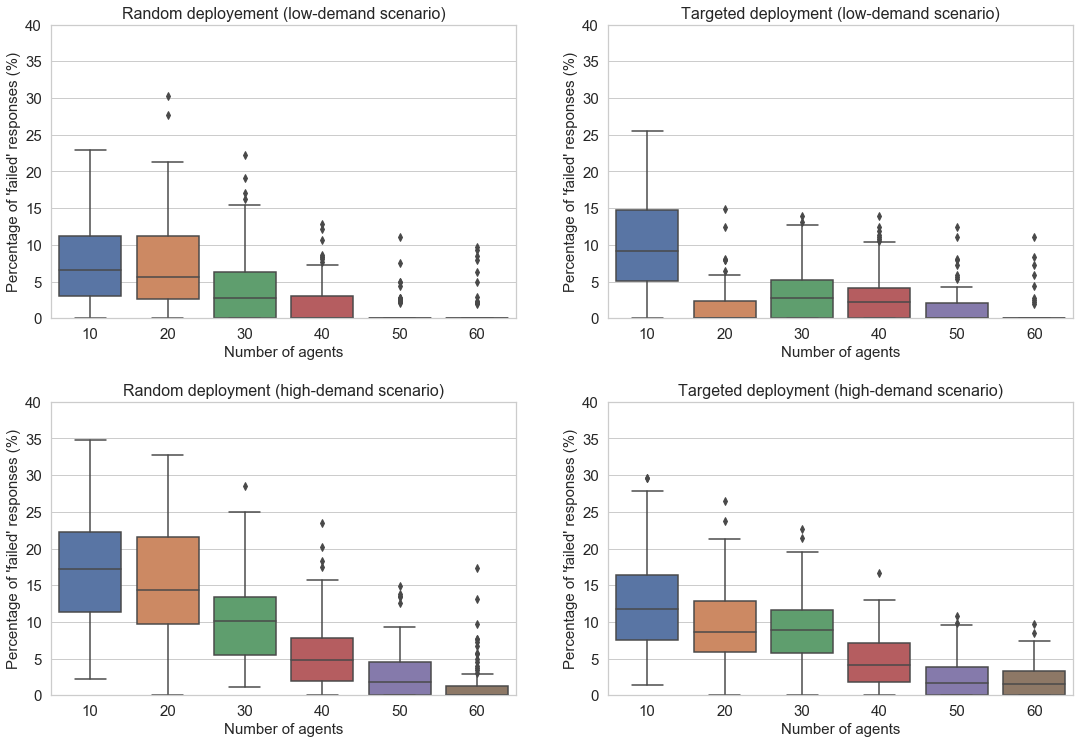

In [79]:
f, axes = plt.subplots(2, 2, figsize=(15, 10))
f.tight_layout(h_pad=5, w_pad=5)

# Scenario 1
plotBoxplots('R', axes[0][0], scenario = 1, metric = 'percent_failed', 
             title = 'Random deployement (low-demand scenario)', 
             ylabel=  "Percentage of 'failed' responses (%)", 
             xlabel='Number of agents',
             ylim = [0,40]
            )
plotBoxplots('T', axes[0][1], scenario = 1, metric= 'percent_failed', 
             title = 'Targeted deployment (low-demand scenario)', 
             ylabel=  "Percentage of 'failed' responses (%)", 
             xlabel='Number of agents',
             ylim = [0,40]
            )

# Scenario 2
plotBoxplots('R', axes[1][0],scenario = 2, metric = 'percent_failed', 
             title = 'Random deployment (high-demand scenario)', 
             ylabel= "Percentage of 'failed' responses (%)", 
             xlabel='Number of agents',
             ylim = [0,40]
            )
plotBoxplots('T', axes[1][1], scenario = 2, metric='percent_failed', 
             title = 'Targeted deployment (high-demand scenario)', 
             ylabel=  "Percentage of 'failed' responses (%)", 
             xlabel='Number of agents',
             ylim = [0,40]
            )

plt.savefig('../Images/ABM_experiments_FailedResponses.png', bbox_inches = 'tight')



plt.show()

Note: There are more failed responses with the targeted configuration because some precinct don't have any agent at all

### Difference between number of agents

In [80]:
scenario = 1

print('Sceanrio:', scenario)
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)
        
H, p = sp.stats.kruskal(*[group["percent_failed"].values for name, group in df.groupby("num_agents")])
print('H: {} - p-value: {}'.format(H, p))
if p > alpha:
    print('\nThe groups are NOT significantly different (fails to reject the null hypothesis)')
else:
    print('\nThe groups are significantly different (reject the null hypothesis)')
    
getEffectSize(H, df)

Sceanrio: 1
H: 424.20137918157957 - p-value: 1.799225370850518e-89

The groups are significantly different (reject the null hypothesis)
esq 0.3537959793007336


'Relatively strong'

In [81]:
scenario = 2

print('Sceanrio:', scenario)
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)
        
H, p = sp.stats.kruskal(*[group["percent_failed"].values for name, group in df.groupby("num_agents")])
print('H: {} - p-value: {}'.format(H, p))
if p > alpha:
    print('\nThe groups are NOT significantly different (fails to reject the null hypothesis)')
else:
    print('\nThe groups are significantly different (reject the null hypothesis)')

getEffectSize(H, df)

Sceanrio: 2
H: 642.8800858764371 - p-value: 1.094969216457761e-136

The groups are significantly different (reject the null hypothesis)
esq 0.536180221748488


'Strong'

### Difference between random versus targeted configuration (for a given number of agents)

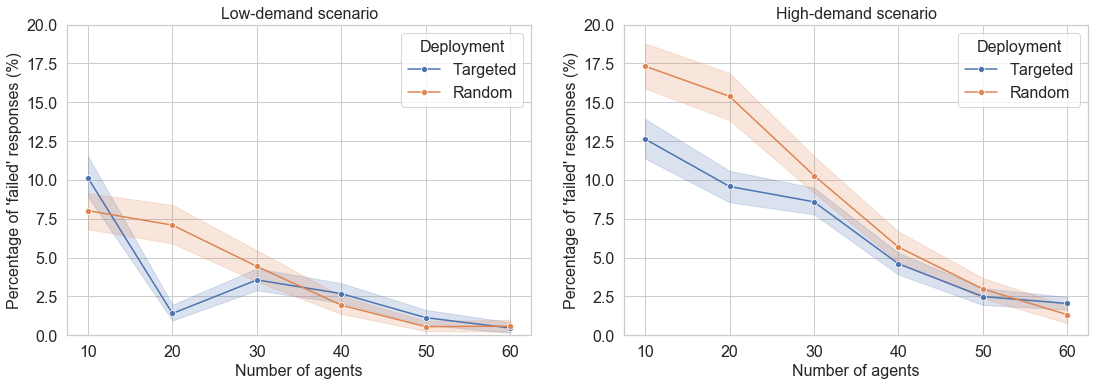

In [146]:
f, axes = plt.subplots(1, 2, figsize=(15, 5))
f.tight_layout(h_pad=5, w_pad=5)

plotLinePlot(axes[0], scenario = 1, metric = 'percent_failed', 
             title = 'Low-demand scenario', 
             ylabel= "Percentage of 'failed' responses (%)", 
             xlabel='Number of agents',
             ylim = [0,20],
             legend_title = 'Deployment',
             legend_labels = ['Targeted', 'Random'],
             legend_loc = 'upper right'
            )

plotLinePlot(axes[1], scenario = 2, metric = 'percent_failed', 
             title = 'High-demand scenario', 
             ylabel= "Percentage of 'failed' responses (%)", 
             xlabel='Number of agents',
             ylim = [0,20],
             legend_title = 'Deployment',
             legend_labels = ['Targeted', 'Random'],
             legend_loc = 'upper right'
            )

plt.savefig('../Images/ABM_experiments_FailedResponses2.png', bbox_inches = 'tight')

In [85]:
scenario = 1
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)

### AVERAGE RESPONSE TIME
res1 = df[['num_agents', 'configuration', 'percent_failed']].groupby(by=['num_agents', 'configuration']).mean()

res1.reset_index(inplace=True)

result = pd.pivot(res1, index='num_agents', columns='configuration', values='percent_failed')
result['Mean difference (%)'] = result['T'] - result['R'] 
result['Percentage change'] = result['Mean difference (%)'] / result['R'] * 100


result.reset_index(inplace=True)

result['p-value'] = [getPValueAndEffectSize('percent_failed', num)[0] for num in result['num_agents']]
result['Effect size'] = [getPValueAndEffectSize('percent_failed', num)[1] for num in result['num_agents']]

result.round(2)

esq 0.028049971360643352
esq 0.31821964451593815
esq 0.00256356669065701
esq 0.023587593251109616
esq 0.022095081327241087
esq 0.0011292755355932383
esq 0.028049971360643352
esq 0.31821964451593815
esq 0.00256356669065701
esq 0.023587593251109616
esq 0.022095081327241087
esq 0.0011292755355932383


configuration,num_agents,R,T,Mean difference (%),Percentage change,p-value,Effect size
0,10,8.02,10.13,2.10,26.20,0.02,Weak
1,20,7.09,1.40,-5.69,-80.24,<0.01,Relatively strong
2,30,4.43,3.56,-0.87,-19.63,0.48,Negligible
3,40,1.93,2.68,0.74,38.45,0.03,Weak
4,50,0.55,1.13,0.58,104.63,0.04,Weak
5,60,0.58,0.46,-0.12,-20.06,0.64,Negligible


In [86]:
scenario = 2
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)

### AVERAGE RESPONSE TIME
res1 = df[['num_agents', 'configuration', 'percent_failed']].groupby(by=['num_agents', 'configuration']).mean()

res1.reset_index(inplace=True)

result = pd.pivot(res1, index='num_agents', columns='configuration', values='percent_failed')
result['Mean difference (%)'] = result['T'] - result['R'] 
result['Percentage change'] = result['Mean difference (%)'] / result['R'] * 100


result.reset_index(inplace=True)

result['p-value'] = [getPValueAndEffectSize('percent_failed', num)[0] for num in result['num_agents']]
result['Effect size'] = [getPValueAndEffectSize('percent_failed', num)[1] for num in result['num_agents']]

result.round(2)

esq 0.09612850335681694
esq 0.15418691900016637
esq 0.01535908680772018
esq 0.005004043179351376
esq 0.0007959193889252365
esq 0.09533224705377226
esq 0.09612850335681694
esq 0.15418691900016637
esq 0.01535908680772018
esq 0.005004043179351376
esq 0.0007959193889252365
esq 0.09533224705377226


configuration,num_agents,R,T,Mean difference (%),Percentage change,p-value,Effect size
0,10,17.33,12.63,-4.69,-27.09,<0.01,Moderate
1,20,15.38,9.58,-5.80,-37.73,<0.01,Moderate
2,30,10.28,8.59,-1.69,-16.48,0.08,Weak
3,40,5.68,4.60,-1.08,-19.01,0.32,Negligible
4,50,2.98,2.49,-0.49,-16.36,0.69,Negligible
5,60,1.32,2.04,0.72,54.30,<0.01,Moderate


In [373]:
"""scenario = 1
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)
    
res1 = df[['num_agents', 'configuration', 'percent_failed']].groupby(by=['num_agents', 'configuration']).agg(['mean', 'std'])
#res1.reset_index(inplace=True)


scenario = 2
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)
    
res2 = df[['num_agents', 'configuration', 'percent_failed']].groupby(by=['num_agents', 'configuration']).agg(['mean', 'std'])
#res2.reset_index(inplace=True)

result = res1.merge(res2, left_index=True, right_index=True)
result.rename(columns={"num_agents": "Number of agents", 'configuration': 'Configuration', 'percent_failed_x': 'Low-demand', 'percent_failed_y': 'High-demand'}, inplace=True)
result.round(1) """

'scenario = 1\nwith open(\'results_benchmark_scenario{}.pkl\'.format(scenario),\'rb\') as f:\n    df = pickle.load(f)\n    \nres1 = df[[\'num_agents\', \'configuration\', \'percent_failed\']].groupby(by=[\'num_agents\', \'configuration\']).agg([\'mean\', \'std\'])\n#res1.reset_index(inplace=True)\n\n\nscenario = 2\nwith open(\'results_benchmark_scenario{}.pkl\'.format(scenario),\'rb\') as f:\n    df = pickle.load(f)\n    \nres2 = df[[\'num_agents\', \'configuration\', \'percent_failed\']].groupby(by=[\'num_agents\', \'configuration\']).agg([\'mean\', \'std\'])\n#res2.reset_index(inplace=True)\n\nresult = res1.merge(res2, left_index=True, right_index=True)\nresult.rename(columns={"num_agents": "Number of agents", \'configuration\': \'Configuration\', \'percent_failed_x\': \'Low-demand\', \'percent_failed_y\': \'High-demand\'}, inplace=True)\nresult.round(1) '

In [374]:
"""plotConfigurationFacets(scenario=1, metric = 'percent_failed', 
             title = '{col_name} agents', 
             ylabel="Percentage of 'failed' responses",)

plt.savefig('../Images/ABM_experiments_FailedResponses_Configurations_Scenario1.png', bbox_inches = 'tight')

"""

'plotConfigurationFacets(scenario=1, metric = \'percent_failed\', \n             title = \'{col_name} agents\', \n             ylabel="Percentage of \'failed\' responses",)\n\nplt.savefig(\'../Images/ABM_experiments_FailedResponses_Configurations_Scenario1.png\', bbox_inches = \'tight\')\n\n'

In [375]:
"""scenario = 1

print('Scenario:', scenario)
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)

for num in df['num_agents'].unique() :
    print('\n',num, 'agents')
    df_subset = df[df['num_agents']==num]
    H, p = sp.stats.kruskal(*[group["percent_failed"].values for name, group in df_subset.groupby(["configuration"])])
    print('H: {} - p-value: {}'.format(H, p))
    if p > alpha:
        print('The groups are NOT significantly different (fails to reject the null hypothesis)')
    else:
        print('*** The groups are significantly different (reject the null hypothesis)')
    getEffectSize(H, df_subset)

"""

'scenario = 1\n\nprint(\'Scenario:\', scenario)\nwith open(\'results_benchmark_scenario{}.pkl\'.format(scenario),\'rb\') as f:\n    df = pickle.load(f)\n\nfor num in df[\'num_agents\'].unique() :\n    print(\'\n\',num, \'agents\')\n    df_subset = df[df[\'num_agents\']==num]\n    H, p = sp.stats.kruskal(*[group["percent_failed"].values for name, group in df_subset.groupby(["configuration"])])\n    print(\'H: {} - p-value: {}\'.format(H, p))\n    if p > alpha:\n        print(\'The groups are NOT significantly different (fails to reject the null hypothesis)\')\n    else:\n        print(\'*** The groups are significantly different (reject the null hypothesis)\')\n    getEffectSize(H, df_subset)\n\n'

In [376]:
"""plotConfigurationFacets(scenario=2, metric = 'percent_failed', 
             title = '{col_name} agents', 
             ylabel="Percentage of 'failed' responses",)

plt.savefig('../Images/ABM_experiments_FailedResponses_Configurations_Scenario2.png', bbox_inches = 'tight')

"""

'plotConfigurationFacets(scenario=2, metric = \'percent_failed\', \n             title = \'{col_name} agents\', \n             ylabel="Percentage of \'failed\' responses",)\n\nplt.savefig(\'../Images/ABM_experiments_FailedResponses_Configurations_Scenario2.png\', bbox_inches = \'tight\')\n\n'

In [377]:
"""scenario = 2

print('Scenario:', scenario)
with open('results_benchmark_scenario{}.pkl'.format(scenario),'rb') as f:
    df = pickle.load(f)

for num in df['num_agents'].unique() :
    print('\n',num, 'agents')
    df_subset = df[df['num_agents']==num]
    H, p = sp.stats.kruskal(*[group["percent_failed"].values for name, group in df_subset.groupby(["configuration"])])
    print('H: {} - p-value: {}'.format(H, p))
    if p > alpha:
        print('The groups are NOT significantly different (fails to reject the null hypothesis)')
    else:
        print('*** The groups are significantly different (reject the null hypothesis)')
    getEffectSize(H, df_subset)

"""

'scenario = 2\n\nprint(\'Scenario:\', scenario)\nwith open(\'results_benchmark_scenario{}.pkl\'.format(scenario),\'rb\') as f:\n    df = pickle.load(f)\n\nfor num in df[\'num_agents\'].unique() :\n    print(\'\n\',num, \'agents\')\n    df_subset = df[df[\'num_agents\']==num]\n    H, p = sp.stats.kruskal(*[group["percent_failed"].values for name, group in df_subset.groupby(["configuration"])])\n    print(\'H: {} - p-value: {}\'.format(H, p))\n    if p > alpha:\n        print(\'The groups are NOT significantly different (fails to reject the null hypothesis)\')\n    else:\n        print(\'*** The groups are significantly different (reject the null hypothesis)\')\n    getEffectSize(H, df_subset)\n\n'

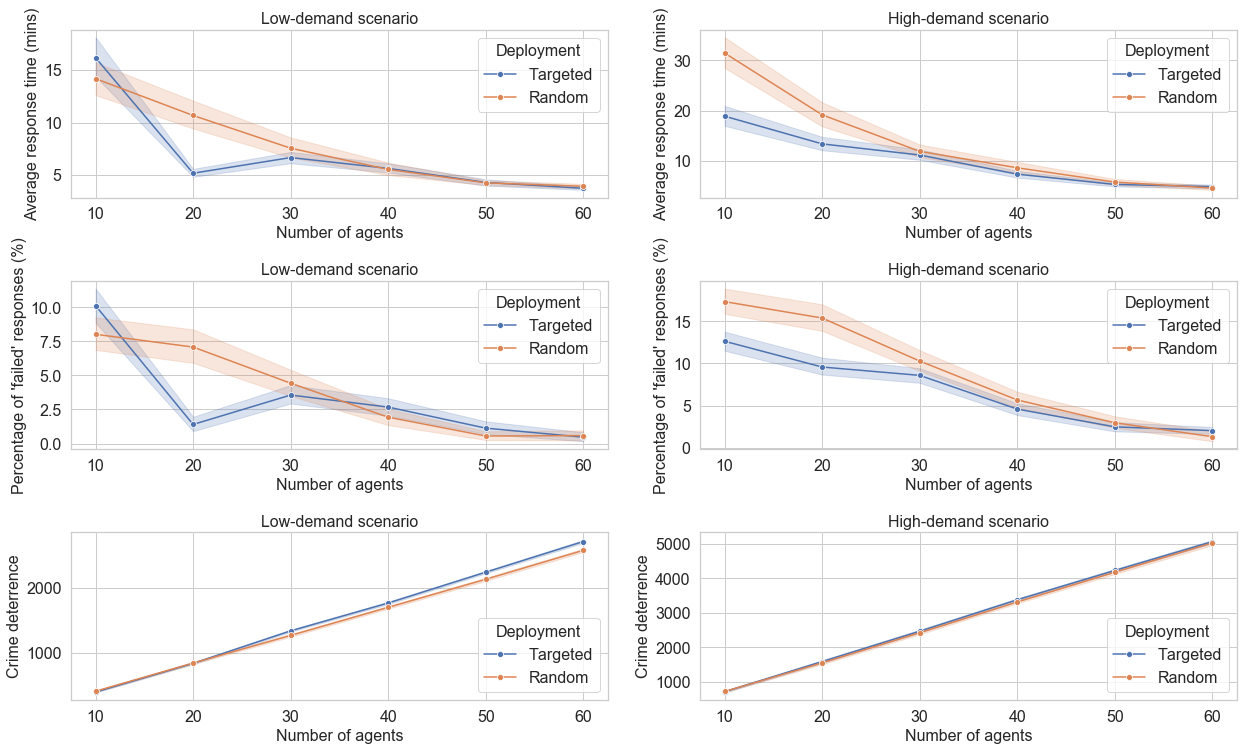

In [378]:
f, axes = plt.subplots(3, 2, figsize=(17, 10))
f.tight_layout(h_pad=5, w_pad=5)

plotLinePlot(axes[0][0], scenario = 1, metric = 'avg_response_time', 
             title = 'Low-demand scenario', 
             ylabel= "Average response time (mins)", 
             xlabel='Number of agents',
             #ylim = [0,3000]
             legend_title = 'Deployment',
             legend_labels = ['Targeted', 'Random'],
             legend_loc = 'upper right'
            )

plotLinePlot(axes[0][1], scenario = 2, metric = 'avg_response_time', 
             title = 'High-demand scenario', 
             ylabel= "Average response time (mins)", 
             xlabel='Number of agents',
             #ylim = [0,3000]
             legend_title = 'Deployment',
             legend_labels = ['Targeted', 'Random'],
             legend_loc = 'upper right'
            )


plotLinePlot(axes[1][0], scenario = 1, metric = 'percent_failed', 
             title = 'Low-demand scenario', 
             ylabel= "Percentage of 'failed' responses (%)", 
             xlabel='Number of agents',
             #ylim = [0,3000]
             legend_title = 'Deployment',
             legend_labels = ['Targeted', 'Random'],
             legend_loc = 'upper right'
            )

plotLinePlot(axes[1][1], scenario = 2, metric = 'percent_failed', 
             title = 'High-demand scenario', 
             ylabel= "Percentage of 'failed' responses (%)", 
             xlabel='Number of agents',
             #ylim = [0,3000]
             legend_title = 'Deployment',
             legend_labels = ['Targeted', 'Random'],
             legend_loc = 'upper right'
            )


plotLinePlot(axes[2][0], scenario = 1, metric = 'deterrence', 
             title = 'Low-demand scenario', 
             ylabel= "Crime deterrence", 
             xlabel='Number of agents',
             #ylim = [0,3000]
             legend_title = 'Deployment',
             legend_labels = ['Targeted', 'Random'],
             legend_loc = 'lower right'
            )

plotLinePlot(axes[2][1], scenario = 2, metric = 'deterrence', 
             title = 'High-demand scenario', 
             ylabel= "Crime deterrence", 
             xlabel='Number of agents',
             #ylim = [0,3000]
             legend_title = 'Deployment',
             legend_labels = ['Targeted', 'Random'],
             legend_loc = 'lower right'
            )

#plt.savefig('../Images/ABM_experiments_FailedResponses2.png', bbox_inches = 'tight')